<a href="https://colab.research.google.com/github/Athallakarenza/Topic-Level-Sentiment-Analysis-Project/blob/main/Topic_Level_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown --id 1s4TFNtN4QcJs6YQiwO7WVgGO7KGqw2FG --output dataset.csv

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1s4TFNtN4QcJs6YQiwO7WVgGO7KGqw2FG
To: /content/dataset.csv
100% 31.6M/31.6M [00:01<00:00, 30.8MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!find "/content/drive/MyDrive" -type d -iname "*Model*"


/content/drive/MyDrive/Model


In [ ]:
!cp -r "/content/drive/MyDrive/Model" /content/


^C


In [ ]:
import pandas as pd


In [ ]:
df = pd.read_csv("dataset.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77488 entries, 0 to 77487
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              77488 non-null  object
 1   userName              77488 non-null  object
 2   userImage             77488 non-null  object
 3   content               77488 non-null  object
 4   score                 77488 non-null  int64 
 5   thumbsUpCount         77488 non-null  int64 
 6   reviewCreatedVersion  70011 non-null  object
 7   at                    77488 non-null  object
 8   replyContent          39381 non-null  object
 9   repliedAt             39381 non-null  object
 10  appVersion            70011 non-null  object
dtypes: int64(2), object(9)
memory usage: 6.5+ MB


# EDA

In [ ]:
df.isnull().sum().sort_values(ascending=False)


,0
repliedAt,38107
replyContent,38107
reviewCreatedVersion,7477
appVersion,7477
userImage,0
reviewId,0
userName,0
thumbsUpCount,0
score,0
content,0


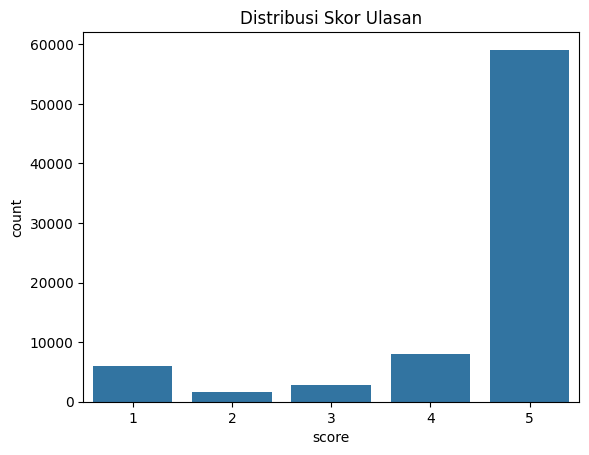

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='score')
plt.title('Distribusi Skor Ulasan')
plt.show()


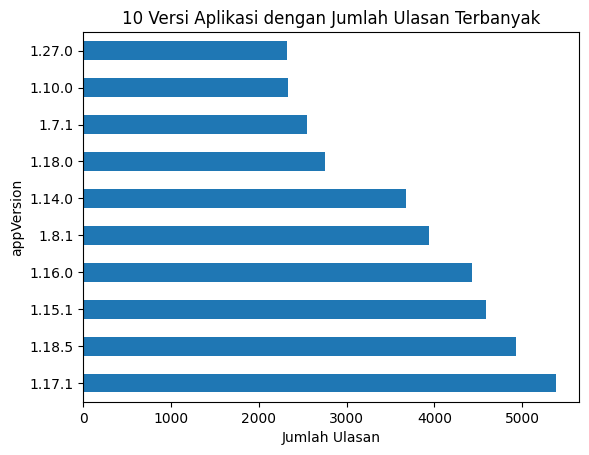

In [ ]:
df['appVersion'].value_counts().head(10).plot(kind='barh')
plt.title('10 Versi Aplikasi dengan Jumlah Ulasan Terbanyak')
plt.xlabel('Jumlah Ulasan')
plt.show()


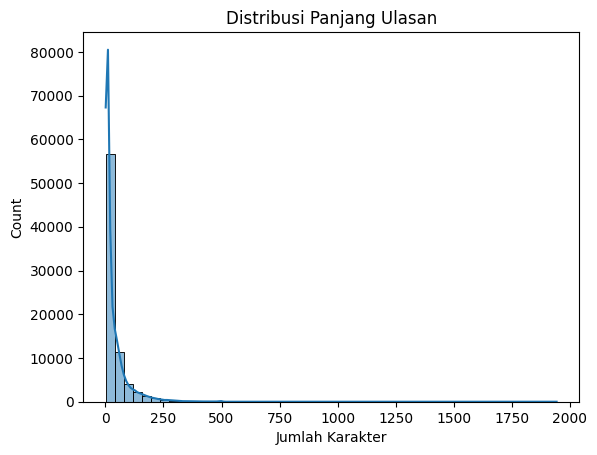

In [ ]:
df['review_length'] = df['content'].astype(str).apply(len)
sns.histplot(df['review_length'], bins=50, kde=True)
plt.title('Distribusi Panjang Ulasan')
plt.xlabel('Jumlah Karakter')
plt.show()


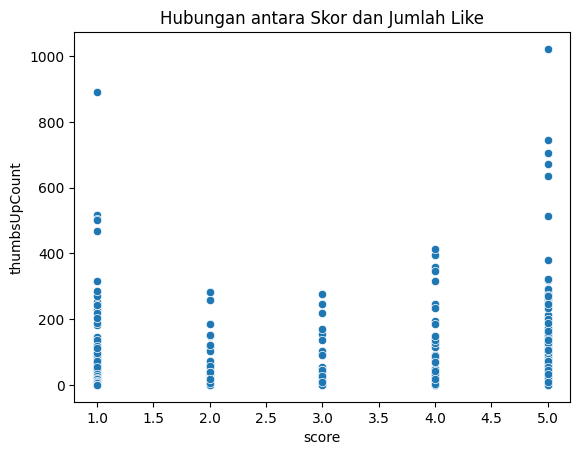

In [ ]:
sns.scatterplot(data=df, x='score', y='thumbsUpCount')
plt.title('Hubungan antara Skor dan Jumlah Like')
plt.show()


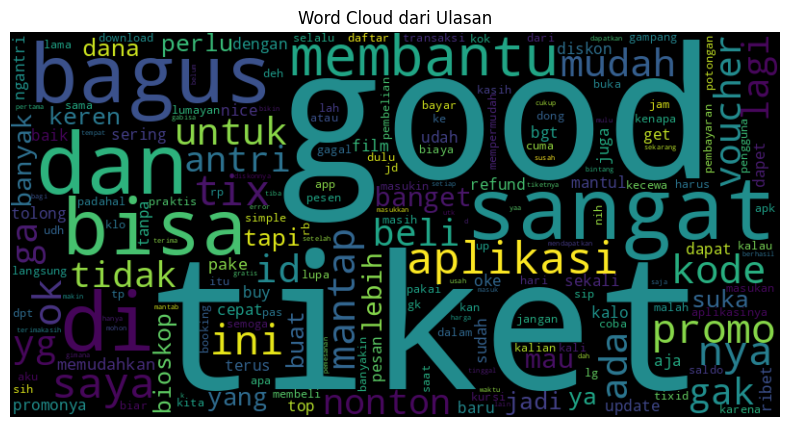

In [ ]:
from collections import Counter
from wordcloud import WordCloud
import re

all_words = ' '.join(df['content'].dropna().astype(str).tolist())
all_words = re.sub(r'[^a-zA-Z\s]', '', all_words.lower())
word_freq = Counter(all_words.split())

wc = WordCloud(width=800, height=400).generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud dari Ulasan')
plt.show()


In [ ]:
data = df[['content', 'score']].copy()


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77488 entries, 0 to 77487
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  77488 non-null  object
 1   score    77488 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ MB


# text preprocessing


In [ ]:
import pandas as pd
from transformers import BertTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import re
import string

# 1. Load data (anggap df sudah berisi kolom 'content' dan 'score')
# df = pd.read_csv('your_file.csv')
df = df[['content', 'score']].copy()

# 2. Label mapping: 1-2 = negatif, 3 = netral, 4-5 = positif
def map_sentiment(score):
    if score <= 3:
        return 0  # non-positive
    else:
        return 1  # postive

df['label'] = df['score'].apply(map_sentiment)

# 3. Text preprocessing function
def preprocess_text(text):
    # Lowercase text
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply text preprocessing
df['cleaned_content'] = df['content'].apply(preprocess_text)

# 4. Tokenizer multilingual BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# 5. Dataset class
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

# 6. Buat dataset dan dataloader
dataset = ReviewDataset(
    texts=df['cleaned_content'].tolist(),
    labels=df['label'].tolist(),
    tokenizer=tokenizer
)

dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# 7. Contoh iterasi dengan tqdm
for batch in tqdm(dataloader, desc="Tokenizing data"):
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['label']

    # (Contoh: proses training atau hanya melihat output batch)
    pass

# Menampilkan DataFrame hasil dengan kolom tambahan
print(df[['content', 'cleaned_content', 'label', 'score']].head())


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

Tokenizing data: 100%|██████████| 4843/4843 [00:32<00:00, 150.15it/s]

                                             content  \
0  Ini aplikasi di Indonesia tetapi sinopsis film...   
1                          Lengkap dan user friendly   
2                                             Baguss   
3  Aplikasi paling keren baru login mau pesan eh ...   
4  Kepada yang terhormat PT elang jaya ini tolong...   

                                     cleaned_content  label  score  
0  ini aplikasi di indonesia tetapi sinopsis film...      0      3  
1                          lengkap dan user friendly      1      5  
2                                             baguss      1      5  
3  aplikasi paling keren baru login mau pesan eh ...      1      5  
4  kepada yang terhormat pt elang jaya ini tolong...      0      1  


In [ ]:
# Simpan hanya kolom yang sudah dibersihkan dan diproses
df[['content', 'cleaned_content', 'label', 'score']].to_csv('preprocessed_reviews.csv', index=False)


In [ ]:
clean_data = pd.read_csv('/content/preprocessed_reviews.csv')

In [ ]:
clean_data.head()

,content,cleaned_content,label,score
0,Ini aplikasi di Indonesia tetapi sinopsis film...,ini aplikasi di indonesia tetapi sinopsis film...,0,3
1,Lengkap dan user friendly,lengkap dan user friendly,1,5
2,Baguss,baguss,1,5
3,Aplikasi paling keren baru login mau pesan eh ...,aplikasi paling keren baru login mau pesan eh ...,1,5
4,Kepada yang terhormat PT elang jaya ini tolong...,kepada yang terhormat pt elang jaya ini tolong...,0,1


# analisis sentiment

In [ ]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler, autocast

# ============================
# HYPERPARAMETER SECTION
# ============================
LEARNING_RATE = 2e-5
BATCH_SIZE = 32
MAX_LEN = 128
EPOCHS = 3
PATIENCE = 1

# Dataset kamu
df = clean_data

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Dataset class
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Split data
train_df, val_df = train_test_split(df, test_size=0.1)
train_dataset = ReviewDataset(train_df['cleaned_content'].tolist(), train_df['label'].tolist(), tokenizer, max_len=MAX_LEN)
val_dataset = ReviewDataset(val_df['cleaned_content'].tolist(), val_df['label'].tolist(), tokenizer, max_len=MAX_LEN)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Model
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)

# Optimizer dan loss
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
scaler = GradScaler()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Training function
def train_model(model, dataloader, optimizer, criterion, device, accumulation_steps=4):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0
    optimizer.zero_grad()
    for step, batch in enumerate(tqdm(dataloader, desc="Training", ncols=100)):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        with autocast():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
        scaler.scale(loss).backward()
        if (step + 1) % accumulation_steps == 0 or (step + 1) == len(dataloader):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        total_loss += loss.item()
        _, preds = torch.max(logits, dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)
    return total_loss / len(dataloader), total_correct / total_samples

# Evaluation function
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss, total_correct, total_samples = 0, 0, 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", ncols=100):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            total_loss += loss.item()
            _, preds = torch.max(logits, dim=1)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)
    return total_loss / len(dataloader), total_correct / total_samples

# Training loop dengan early stopping
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    train_loss, train_acc = train_model(model, train_dataloader, optimizer, criterion, device)
    val_loss, val_acc = evaluate_model(model, val_dataloader, criterion, device)
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Kamu bisa simpan model terbaik di sini, contoh:
        # torch.save(model.state_dict(), 'best_model.pt')
    else:
        epochs_no_improve += 1
        print(f"EarlyStopping counter: {epochs_no_improve}/{PATIENCE}")
        if epochs_no_improve >= PATIENCE:
            print("Early stopping triggered!")
            break


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-32-0626d561c4c2>:71: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Epoch 1/3


Training:   0%|                                                            | 0/2180 [00:00<?, ?it/s]<ipython-input-32-0626d561c4c2>:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Evaluating: 100%|█████████████████████████████████████████████████| 243/243 [00:50<00:00,  4.85it/s]


Train Loss: 0.2040, Train Acc: 0.9249
Val Loss: 0.1991, Val Acc: 0.9313

Epoch 2/3


Evaluating: 100%|█████████████████████████████████████████████████| 243/243 [00:50<00:00,  4.86it/s]


Train Loss: 0.1583, Train Acc: 0.9467
Val Loss: 0.1762, Val Acc: 0.9396

Epoch 3/3


Evaluating: 100%|█████████████████████████████████████████████████| 243/243 [00:49<00:00,  4.87it/s]

Train Loss: 0.1414, Train Acc: 0.9535
Val Loss: 0.1810, Val Acc: 0.9374
EarlyStopping counter: 1/1
Early stopping triggered!


Hyperparameter tuning

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# =======================================
# Hyperparameter grid
# =======================================
param_grid = {
    'learning_rate': [2e-5, 3e-5],
    'batch_size': [32],
    'max_len': [128, 256],
    'epochs': [3],
}

param_combinations = list(itertools.product(
    param_grid['learning_rate'],
    param_grid['batch_size'],
    param_grid['max_len'],
    param_grid['epochs']
))

results = []
best_val_acc = 0
best_model_path = 'best_model.pt'
best_params = None

# =======================================
# Tuning loop
# =======================================
for lr, batch_size, max_len, epochs in param_combinations:
    print(f"\n=== LR: {lr}, Batch: {batch_size}, MaxLen: {max_len}, Epochs: {epochs} ===")

    # Dataset ulang sesuai max_len
    train_dataset = ReviewDataset(train_df['cleaned_content'].tolist(), train_df['label'].tolist(), tokenizer, max_len=max_len)
    val_dataset = ReviewDataset(val_df['cleaned_content'].tolist(), val_df['label'].tolist(), tokenizer, max_len=max_len)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

    # Model baru
    model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)
    optimizer = AdamW(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    scaler = GradScaler()
    model.to(device)

    # Early stopping reset
    best_epoch_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        train_loss, train_acc = train_model(model, train_dataloader, optimizer, criterion, device)
        val_loss, val_acc = evaluate_model(model, val_dataloader, criterion, device)
        print(f"Epoch {epoch+1}/{epochs} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        if val_loss < best_epoch_val_loss:
            best_epoch_val_loss = val_loss
            epochs_no_improve = 0
            # Simpan model jika ini model terbaik
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_params = (lr, batch_size, max_len, epochs)
                torch.save(model.state_dict(), best_model_path)
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= PATIENCE:
                print("Early stopping triggered!")
                break

    results.append({
        'learning_rate': lr,
        'batch_size': batch_size,
        'max_len': max_len,
        'epochs': epochs,
        'val_accuracy': val_acc
    })

# =======================================
# Show tuning results
# =======================================
results_df = pd.DataFrame(results)
print("\n=== Hasil Hyperparameter Tuning ===")
print(results_df.sort_values('val_accuracy', ascending=False))



=== LR: 2e-05, Batch: 32, MaxLen: 128, Epochs: 3 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-33-5c2640b34797>:43: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Training:   0%|                                                            | 0/2180 [00:00<?, ?it/s]<ipython-input-32-0626d561c4c2>:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Evaluating: 100%|█████████████████████████████████████████████████| 243/243 [00:50<00:00,  4.77it/s]


Epoch 1/3 - Train Acc: 0.9247, Val Acc: 0.9395


Evaluating: 100%|█████████████████████████████████████████████████| 243/243 [00:49<00:00,  4.87it/s]


Epoch 2/3 - Train Acc: 0.9459, Val Acc: 0.9412
Early stopping triggered!

=== LR: 2e-05, Batch: 32, MaxLen: 256, Epochs: 3 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|█████████████████████████████████████████████████| 243/243 [01:45<00:00,  2.30it/s]


Epoch 1/3 - Train Acc: 0.9276, Val Acc: 0.9357


Evaluating: 100%|█████████████████████████████████████████████████| 243/243 [01:45<00:00,  2.31it/s]


Epoch 2/3 - Train Acc: 0.9453, Val Acc: 0.9406


Evaluating: 100%|█████████████████████████████████████████████████| 243/243 [01:45<00:00,  2.31it/s]


Epoch 3/3 - Train Acc: 0.9525, Val Acc: 0.9404
Early stopping triggered!

=== LR: 3e-05, Batch: 32, MaxLen: 128, Epochs: 3 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|█████████████████████████████████████████████████| 243/243 [00:49<00:00,  4.87it/s]


Epoch 1/3 - Train Acc: 0.9269, Val Acc: 0.9400


Evaluating: 100%|█████████████████████████████████████████████████| 243/243 [00:49<00:00,  4.87it/s]


Epoch 2/3 - Train Acc: 0.9467, Val Acc: 0.9391
Early stopping triggered!

=== LR: 3e-05, Batch: 32, MaxLen: 256, Epochs: 3 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|█████████████████████████████████████████████████| 243/243 [01:45<00:00,  2.30it/s]


Epoch 1/3 - Train Acc: 0.9285, Val Acc: 0.9410


Evaluating: 100%|█████████████████████████████████████████████████| 243/243 [01:45<00:00,  2.31it/s]

Epoch 2/3 - Train Acc: 0.9482, Val Acc: 0.9414
Early stopping triggered!

=== Hasil Hyperparameter Tuning ===
   learning_rate  batch_size  max_len  epochs  val_accuracy
3        0.00003          32      256       3      0.941412
0        0.00002          32      128       3      0.941154
1        0.00002          32      256       3      0.940379
2        0.00003          32      128       3      0.939089


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 243/243 [01:45<00:00,  2.31it/s]


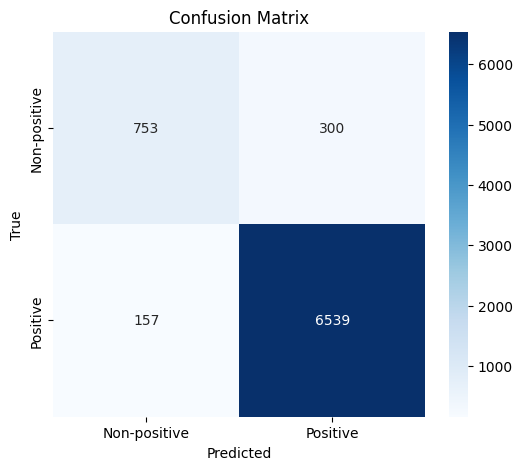

<ipython-input-34-be09f463fd3c>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Non-positive', 'Positive'], y=sentiment_counts.sort_index(), palette='viridis')



Classification Report:
               precision    recall  f1-score   support

Non-positive       0.83      0.72      0.77      1053
    Positive       0.96      0.98      0.97      6696

    accuracy                           0.94      7749
   macro avg       0.89      0.85      0.87      7749
weighted avg       0.94      0.94      0.94      7749



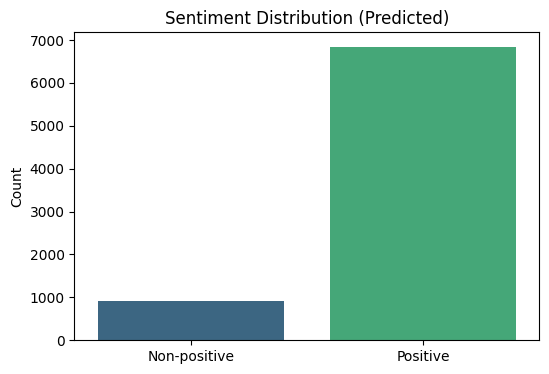


Best model saved to: best_model.pt


In [ ]:
from tqdm import tqdm

# Load best model
best_model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

# Buat ulang val dataloader dengan best max_len
_, _, best_max_len, _ = best_params
val_dataset = ReviewDataset(val_df['cleaned_content'].tolist(), val_df['label'].tolist(), tokenizer, max_len=best_max_len)
val_dataloader = DataLoader(val_dataset, batch_size=32)

# Evaluasi akhir dengan tqdm progress bar
best_model.eval()
all_labels, all_preds = [], []
with torch.no_grad():
    for batch in tqdm(val_dataloader, desc="Evaluating"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = best_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-positive', 'Positive'], yticklabels=['Non-positive', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
report = classification_report(all_labels, all_preds, target_names=['Non-positive', 'Positive'])
print("\nClassification Report:\n", report)

# Insight: Distribusi Prediksi
val_df = val_df.reset_index(drop=True)
val_df['predicted'] = all_preds
sentiment_counts = val_df['predicted'].value_counts()
plt.figure(figsize=(6, 4))
sns.barplot(x=['Non-positive', 'Positive'], y=sentiment_counts.sort_index(), palette='viridis')
plt.title('Sentiment Distribution (Predicted)')
plt.ylabel('Count')
plt.show()

print(f"\nBest model saved to: {best_model_path}")


In [ ]:
# 12. Simpan model dan tokenizer
model_path = "/content/drive/MyDrive/Sentimen_model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

print(f"Model dan tokenizer disimpan di folder: {model_path}")


Model dan tokenizer disimpan di folder: /content/drive/MyDrive/Sentimen_model


In [ ]:
def predict_sentiment(text, model, tokenizer, device, max_len=128):
    model.eval()

    # Tokenisasi teks
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=1).item()

    label_map = {0: "Non-Positive", 1: "Positive"}
    return label_map[prediction]


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load tokenizer & model
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
model = BertForSequenceClassification.from_pretrained("sentiment_model")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Prediksi kalimat baru
input_text = "kenapa loadingnya lama?"
result = predict_sentiment(input_text, model, tokenizer, device)
print("Prediksi Sentimen:", result)




Prediksi Sentimen: Non-Positive


# visualisasi setelah model didapat

In [ ]:
from transformers import BertForSequenceClassification

model_path = "sentiment_model"  # atau nama folder kamu
model = BertForSequenceClassification.from_pretrained(model_path)
model.to(device)
model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [ ]:
texts = clean_data['cleaned_content'].tolist()


In [ ]:
class ReviewDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
        }

predict_dataset = ReviewDataset(texts, tokenizer)
predict_loader = DataLoader(predict_dataset, batch_size=32, num_workers=2)


In [ ]:
predicted_labels = []

model.eval()
with torch.no_grad():
    for batch in tqdm(predict_loader, desc="Predicting", ncols=100):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        predicted_labels.extend(preds.cpu().numpy())


Predicting: 100%|███████████████████████████████████████████████| 2422/2422 [08:06<00:00,  4.98it/s]


In [ ]:
clean_data['predicted_label'] = predicted_labels
label_map = {0: 'Non-positive', 1: 'Positive'}
clean_data['sentiment'] = clean_data['predicted_label'].map(label_map)


<ipython-input-44-6c5c910bc140>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=clean_data, palette='Set2')


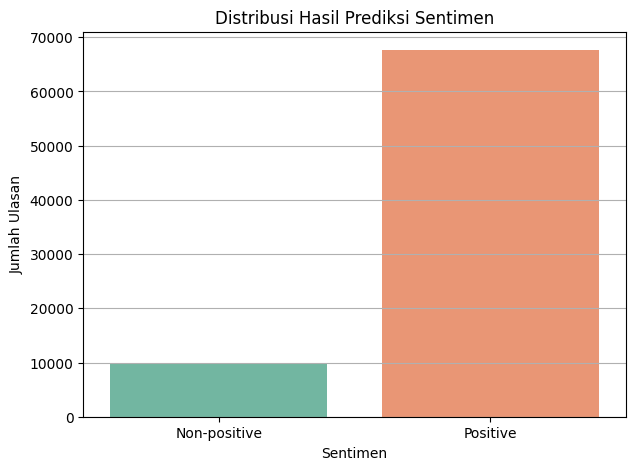

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
sns.countplot(x='sentiment', data=clean_data, palette='Set2')
plt.title('Distribusi Hasil Prediksi Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Ulasan')
plt.grid(True, axis='y')
plt.show()


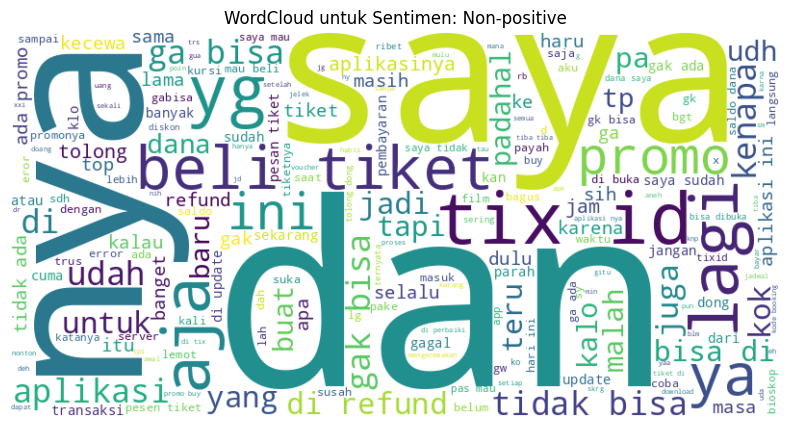

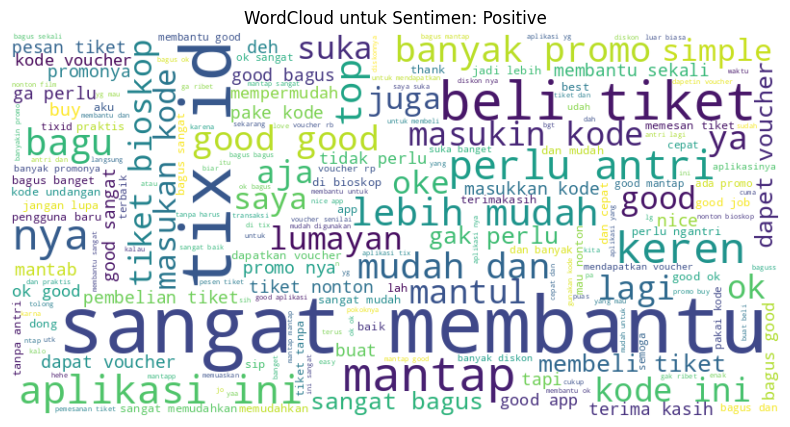

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for sentiment in clean_data['sentiment'].unique():
    subset = clean_data[clean_data['sentiment'] == sentiment]['cleaned_content'].dropna()
    text = ' '.join(map(str, subset))

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud untuk Sentimen: {sentiment}')
    plt.show()


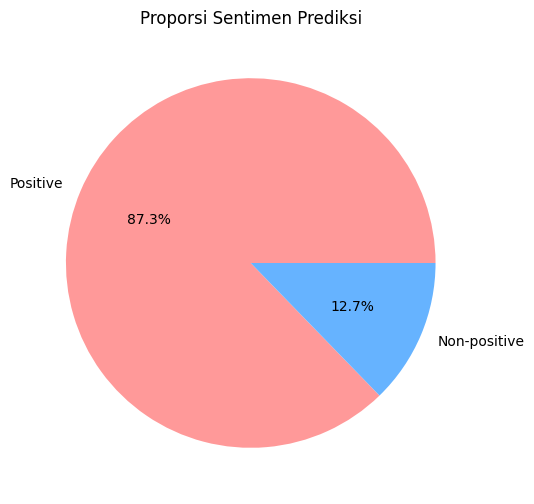

In [ ]:
plt.figure(figsize=(6, 6))
clean_data['sentiment'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Proporsi Sentimen Prediksi')
plt.ylabel('')
plt.show()


In [ ]:
# Tentukan path untuk menyimpan file
save_path = '/content/drive/MyDrive/Data Eki/clean_data_with_sentiment.csv'

# Simpan DataFrame ke file CSV
clean_data.to_csv(save_path, index=False)

print(f"Dataset berhasil disimpan di: {save_path}")

Dataset berhasil disimpan di: /content/drive/MyDrive/Data Eki/clean_data_with_sentiment.csv


# Topic Level Sentiment

In [ ]:
clean_data = pd.read_csv("/content/drive/MyDrive/clean_data_with_sentiment.csv")

In [ ]:
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
import umap
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN
import plotly.express as px
import warnings

In [ ]:
clean_data

,content,cleaned_content,label,score,predicted_label,sentiment
0,Ini aplikasi di Indonesia tetapi sinopsis film...,ini aplikasi di indonesia tetapi sinopsis film...,0,3,0,Non-positive
1,Lengkap dan user friendly,lengkap dan user friendly,1,5,1,Positive
2,Baguss,baguss,1,5,1,Positive
3,Aplikasi paling keren baru login mau pesan eh ...,aplikasi paling keren baru login mau pesan eh ...,1,5,1,Positive
4,Kepada yang terhormat PT elang jaya ini tolong...,kepada yang terhormat pt elang jaya ini tolong...,0,1,0,Non-positive
...,...,...,...,...,...,...
77483,Ini tuker tiket apa di langsung masuk,ini tuker tiket apa di langsung masuk,1,5,1,Positive
77484,Pilih untuk tanggal berikutnya gk bs yah harus...,pilih untuk tanggal berikutnya gk bs yah harus...,0,2,0,Non-positive
77485,Suka dan lebih simple aplikasi yang ini,suka dan lebih simple aplikasi yang ini,1,5,1,Positive
77486,Sukaaaa aaa gaperlu antre lagi kalau mau bayar,sukaaaa aaa gaperlu antre lagi kalau mau bayar,1,5,1,Positive


In [ ]:
import re
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt_tab')
# Download NLTK resources (run once)
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Function to clean text for Indonesian language
def clean_text(text):
    if isinstance(text, str):
        # Remove URLs, special characters, and numbers
        text = re.sub(r'http\S+', '', text)
        # Adjusted to keep Indonesian characters with diacritics
        text = re.sub(r'[^a-zA-Z0-9\s\u00C0-\u00FF]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        # Convert to lowercase
        text = text.lower()
        return text
    return ""

# Apply text cleaning
clean_data['cleaned_content'] = clean_data['cleaned_content'].apply(clean_text)


# Create custom stopwords list - app-specific words may be added here
stop_words = set(stopwords.words('indonesian'))
app_specific_stopwords = {
    'aplikasi', 'app', 'pakai', 'memakai', 'menggunakan', 'digunakan', 'pengguna', 'user'
}
stop_words.update(app_specific_stopwords)

# Initialize CountVectorizer with stopwords
vectorizer = CountVectorizer(stop_words=list(stop_words))
vectorizer
# Initialize UMAP for dimensionality reduction
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
umap_model
# Initialize HDBSCAN for clustering
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', prediction_data=True)
hdbscan_model

HDBSCAN(min_cluster_size=10, prediction_data=True)

In [ ]:
# Function to clean text for Indonesian language
def clean_text(text):
    if isinstance(text, str):
        # Remove URLs, special characters, and numbers
        text = re.sub(r'http\S+', '', text)
        # Adjusted to keep Indonesian characters with diacritics
        text = re.sub(r'[^a-zA-Z0-9\s\u00C0-\u00FF]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        # Convert to lowercase
        text = text.lower()
        return text
    return ""

# Apply text cleaning
clean_data['cleaned_content'] = clean_data['cleaned_content'].apply(clean_text)


In [ ]:
# Remove empty reviews
clean_data = clean_data[clean_data['cleaned_content'] != ""].reset_index(drop=True)
print(f"Number of reviews after cleaning: {len(df)}")

Number of reviews after cleaning: 77488


In [ ]:
# Create custom stopwords list - app-specific words may be added here
stop_words = set(stopwords.words('indonesian'))
app_specific_stopwords = {
    'aplikasi', 'app', 'pakai', 'memakai', 'menggunakan', 'digunakan', 'pengguna', 'user'
}
stop_words.update(app_specific_stopwords)

In [ ]:
# Initialize CountVectorizer with stopwords
vectorizer = CountVectorizer(stop_words=list(stop_words))
vectorizer

CountVectorizer(stop_words=['tengah', 'andalah', 'setiap', 'anda', 'hari',
                            'masa', 'nanti', 'semula', 'bawah', 'mendapatkan',
                            'sepihak', 'sedang', 'jauh', 'masalahnya', 'masing',
                            'mula', 'ditunjuki', 'selaku', 'menanyakan',
                            'memungkinkan', 'karena', 'berturut-turut', 'empat',
                            'sinilah', 'terakhir', 'bermula', 'diperlukan',
                            'ialah', 'begitupun', 'akan', ...])

In [ ]:
# Initialize UMAP for dimensionality reduction
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
umap_model

UMAP(metric='cosine', min_dist=0.0, n_components=5, random_state=42)

In [ ]:
# Initialize HDBSCAN for clustering
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', prediction_data=True)
hdbscan_model

HDBSCAN(min_cluster_size=10, prediction_data=True)

In [ ]:
# Create a list of documents for topic modeling
documents = clean_data['cleaned_content'].tolist()
documents

['ini aplikasi di indonesia tetapi sinopsis film rata menggunakan bahasa inggris harusnya ada menu terjemahan nya jika memang dari pihak film memberikan sinopsis berbahasa inggris',
 'lengkap dan user friendly',
 'baguss',
 'aplikasi paling keren baru login mau pesan eh ternyata yang mau di tonton ada diskon buy get gak pake lama langsung gercep saya ama temen',
 'kepada yang terhormat pt elang jaya ini tolong perbaiki napa di hp saya itu erorr terus coba lagi nanti gitu tolong perbaiki napa masa orang nya rapi rapi di kantor aplikasinya bobrok kan aneh it nya kalau ga becus ganti aja sama yang niat kerja saya bukannya so atau apapun tapi saya mau lihat lihat film atau booking film buat nonton di bioskop jadi susah dan terganggu terimakasih banyak',
 'wow bingits',
 'oumayan lengkap dan wort it',
 'staffnya sombongx gak punya jiwa pelayanan yang ramah jauh banget berubah sifatx staffnya khususnya di sumarecon',
 'aplikasi ini bagus untuk para penggemar nonton bioskop',
 'ini di update 

In [ ]:
print("\nLoading multilingual BERT model...")
# Load pre-trained multilingual sentence transformer model suitable for Indonesian language
sentence_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
sentence_model


Loading multilingual BERT model...


SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

In [ ]:
print("\nTraining BERTopic model...")
# Create BERTopic model - using multilingual embedding model for Indonesian language
topic_model = BERTopic(
    embedding_model=SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2'),  # Better for Indonesian language
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer,
    nr_topics=10,
    verbose=True
)
topic_model


Training BERTopic model...


In [ ]:
# Fit the model and transform documents
new_topics, new_probs = topic_model.fit_transform(documents)

2025-05-29 17:02:05,084 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/2362 [00:00<?, ?it/s]

2025-05-29 17:02:49,723 - BERTopic - Embedding - Completed ✓
2025-05-29 17:02:49,725 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-29 17:05:59,576 - BERTopic - Dimensionality - Completed ✓
2025-05-29 17:05:59,579 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-29 17:06:08,724 - BERTopic - Cluster - Completed ✓
2025-05-29 17:06:08,725 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-05-29 17:06:10,840 - BERTopic - Representation - Completed ✓
2025-05-29 17:06:10,848 - BERTopic - Topic reduction - Reducing number of topics
2025-05-29 17:06:10,988 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-29 17:06:12,485 - BERTopic - Representation - Completed ✓
2025-05-29 17:06:12,502 - BERTopic - Topic reduction - Reduced number of topics from 690 to 10


In [ ]:
# Add topics to the dataframe
clean_data['10_topics'] = new_topics

# Get topic info
topic_info = topic_model.get_topic_info()
print("\nTop topics:")
topic_info


Top topics:


,Topic,Count,Name,Representation,Representative_Docs
0,-1,17314,-1_tiket_di_dan_bisa,"[tiket, di, dan, bisa, saya, promo, tix, ini, ...",[terimakasih tix id beli tiket nonton jadi mur...
1,0,40845,0_good_ok_bagus_sangat,"[good, ok, bagus, sangat, membantu, mantap, sa...","[good, good, good]"
2,1,11947,1_tiket_kode_dan_untuk,"[tiket, kode, dan, untuk, promo, di, voucher, ...","[mudah dan praktis untuk beli tiket bioskop, a..."
3,2,4368,2_aplikasi_app_ini_aplikasinya,"[aplikasi, app, ini, aplikasinya, tix, good, i...","[good aplikasi, good aplikasi, good aplikasi]"
4,3,464,3_server_tidak_bisa_password,"[server, tidak, bisa, password, saya, mau, pad...",[tidak bisa aktifkan dana muncul teks kondisi ...
5,4,307,4_update_update mulu_mulu_update terus,"[update, update mulu, mulu, update terus, seri...","[update, update, update]"
6,5,234,5_waktu_jadwal_tanggal_bisa,"[waktu, jadwal, tanggal, bisa, lambat, menghem...","[menghemat waktu, menghemat waktu, menghemat w..."
7,6,38,6_indonesia_di indonesia_di_seluruh,"[indonesia, di indonesia, di, seluruh, film, i...",[sayangnya blm mencakup seluruh bioskop di ind...
8,7,33,7_okok_smoga_okok okok_okokokok,"[okok, smoga, okok okok, okokokok, okok okokok...","[okok, okok, okok]"
9,8,21,8_php_php promo_promo php_php aplikasi,"[php, php promo, promo php, php aplikasi, apli...","[promo php, promo php, php promo]"


In [ ]:
topic_model.visualize_topics(custom_labels=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Tentukan path penyimpanan di Google Drive
save_path = '/content/drive/My Drive/bertopic_model'

# Simpan model
topic_model.save(save_path)

2025-05-29 17:06:25,073 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
topic_minus1_df = clean_data[clean_data['10_topics'] == -1]
topic_minus1_df.head()

,content,cleaned_content,label,score,predicted_label,sentiment,10_topics
4,Kepada yang terhormat PT elang jaya ini tolong...,kepada yang terhormat pt elang jaya ini tolong...,0,1,0,Non-positive,-1
5,wow bingits,wow bingits,1,5,1,Positive,-1
6,"Oumayan lengkap, dan wort it",oumayan lengkap dan wort it,0,3,1,Positive,-1
7,Staffnya sombong2x gak punya jiwa pelayanan ya...,staffnya sombongx gak punya jiwa pelayanan yan...,0,1,0,Non-positive,-1
9,Ini di update bukan tambah gampang buka atau p...,ini di update bukan tambah gampang buka atau p...,0,2,0,Non-positive,-1


In [ ]:
topic_labels = {
    0: "Feedback Positif dan Kepuasan",
    1: "Pembelian Tiket & Promo",
    2: "Aplikasi TIX dan Pengalaman Pengguna",
    3: "Masalah Teknis & Akses Login",
    4: "Update Aplikasi yang Terlalu Sering",
    5: "Efisiensi Waktu & Penjadwalan",
    6: "Film & Bioskop di Indonesia",
    7: "Ucapan Harapan & Doa Positif (User Emosi Ringan)",
    8: "Kekecewaan pada Promo (PHP = harapan palsu)"
}

# Buat kolom label topik deskriptif
clean_data['topic_label'] = clean_data['10_topics'].map(topic_labels)


In [ ]:
save_path = '/content/drive/MyDrive/clean_data_with_sentiment_and_topic.csv'
clean_data.to_csv(save_path, index=False)
print(f"\nHasil akhir disimpan di: {save_path}")



Hasil akhir disimpan di: /content/drive/MyDrive/clean_data_with_sentiment_and_topic.csv


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
# Hitung jumlah sentimen per label topik
sentiment_distribution = clean_data.groupby(['topic_label', 'sentiment']).size().reset_index(name='count')

# Hitung total per topik
total_per_topic = sentiment_distribution.groupby('topic_label')['count'].transform('sum')

# Tambahkan kolom persentase
sentiment_distribution['percentage'] = (sentiment_distribution['count'] / total_per_topic) * 100


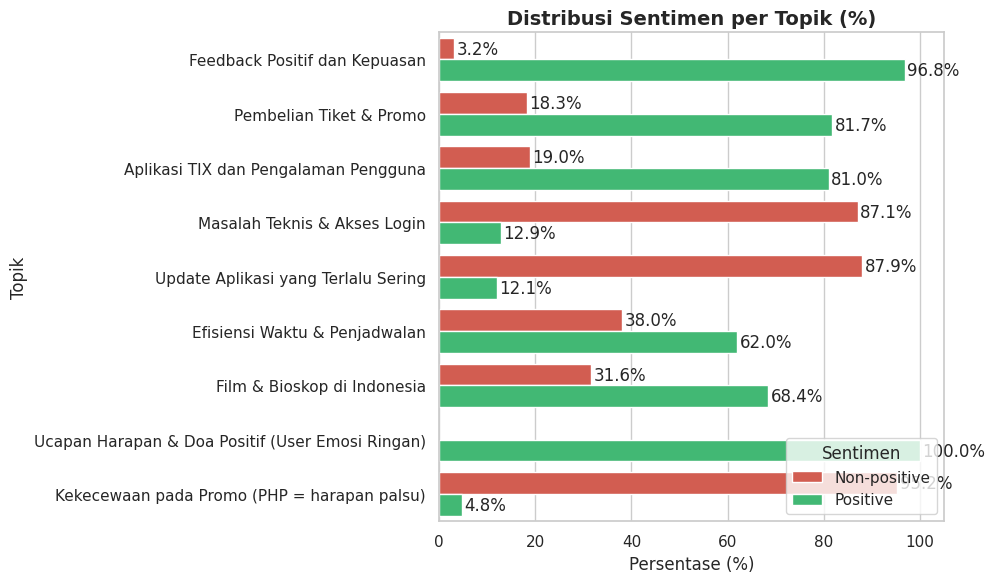

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set gaya visual
sns.set(style="whitegrid")

# Tetapkan urutan topik agar sesuai label yang kamu buat
sentiment_distribution['topic_label'] = pd.Categorical(
    sentiment_distribution['topic_label'],
    categories=[topic_labels[t] for t in sorted(topic_labels.keys())],
    ordered=True
)

# Buat palet warna custom
custom_palette = {
    'Positive': '#2ecc71',       # Hijau terang
    'Non-positive': '#e74c3c'    # Merah terang
}

# Buat plot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    data=sentiment_distribution,
    y='topic_label',
    x='percentage',
    hue='sentiment',
    palette=custom_palette
)

# Tambahkan label persentase di atas bar
for p in barplot.patches:
    width = p.get_width()
    if width > 1:
        plt.text(width + 0.5, p.get_y() + p.get_height() / 2,
                 f'{width:.1f}%', va='center')

# Finalisasi tampilan
plt.title('Distribusi Sentimen per Topik (%)', fontsize=14, weight='bold')
plt.xlabel('Persentase (%)')
plt.ylabel('Topik')
plt.legend(title='Sentimen', loc='lower right')
plt.tight_layout()
plt.show()




In [ ]:
print("Analyzing sentiment for top topics...\n")

# Pastikan rating float
clean_data['score'] = clean_data['score'].astype(float)

# Ambil semua topik unik
unique_topics = sorted(clean_data['10_topics'].unique())

for topic in unique_topics:
    topic_data = clean_data[clean_data['10_topics'] == topic]

    if len(topic_data) == 0:
        continue

    avg_rating = topic_data['score'].mean()
    sentiment_counts = topic_data['sentiment'].value_counts(normalize=True) * 100
    pos = sentiment_counts.get('Positive', 0)
    non_pos = sentiment_counts.get('Non-positive', 0)

    topic_name = topic_labels.get(topic, f"Topic {topic}")
    print(f"Topic {topic}: {topic_name} - Avg Rating = {avg_rating:.2f}, Positive = {pos:.1f}%, Non-positive = {non_pos:.1f}%")


Analyzing sentiment for top topics...

Topic -1: Topic -1 - Avg Rating = 4.00, Positive = 72.6%, Non-positive = 27.4%
Topic 0: Feedback Positif dan Kepuasan - Avg Rating = 4.75, Positive = 96.8%, Non-positive = 3.2%
Topic 1: Pembelian Tiket & Promo - Avg Rating = 4.24, Positive = 81.7%, Non-positive = 18.3%
Topic 2: Aplikasi TIX dan Pengalaman Pengguna - Avg Rating = 4.28, Positive = 81.0%, Non-positive = 19.0%
Topic 3: Masalah Teknis & Akses Login - Avg Rating = 2.08, Positive = 12.9%, Non-positive = 87.1%
Topic 4: Update Aplikasi yang Terlalu Sering - Avg Rating = 2.59, Positive = 12.1%, Non-positive = 87.9%
Topic 5: Efisiensi Waktu & Penjadwalan - Avg Rating = 3.82, Positive = 62.0%, Non-positive = 38.0%
Topic 6: Film & Bioskop di Indonesia - Avg Rating = 3.74, Positive = 68.4%, Non-positive = 31.6%
Topic 7: Ucapan Harapan & Doa Positif (User Emosi Ringan) - Avg Rating = 4.88, Positive = 100.0%, Non-positive = 0.0%
Topic 8: Kekecewaan pada Promo (PHP = harapan palsu) - Avg Rating = 

In [ ]:
clean_data

,content,cleaned_content,label,score,predicted_label,sentiment,10_topics,topic_label
0,Ini aplikasi di Indonesia tetapi sinopsis film...,ini aplikasi di indonesia tetapi sinopsis film...,0,3.0,0,Non-positive,6,Film & Bioskop di Indonesia
1,Lengkap dan user friendly,lengkap dan user friendly,1,5.0,1,Positive,2,Aplikasi TIX dan Pengalaman Pengguna
2,Baguss,baguss,1,5.0,1,Positive,0,Feedback Positif dan Kepuasan
3,Aplikasi paling keren baru login mau pesan eh ...,aplikasi paling keren baru login mau pesan eh ...,1,5.0,1,Positive,2,Aplikasi TIX dan Pengalaman Pengguna
4,Kepada yang terhormat PT elang jaya ini tolong...,kepada yang terhormat pt elang jaya ini tolong...,0,1.0,0,Non-positive,-1,NaN
...,...,...,...,...,...,...,...,...
75566,Ini tuker tiket apa di langsung masuk,ini tuker tiket apa di langsung masuk,1,5.0,1,Positive,1,Pembelian Tiket & Promo
75567,Pilih untuk tanggal berikutnya gk bs yah harus...,pilih untuk tanggal berikutnya gk bs yah harus...,0,2.0,0,Non-positive,5,Efisiensi Waktu & Penjadwalan
75568,Suka dan lebih simple aplikasi yang ini,suka dan lebih simple aplikasi yang ini,1,5.0,1,Positive,2,Aplikasi TIX dan Pengalaman Pengguna
75569,Sukaaaa aaa gaperlu antre lagi kalau mau bayar,sukaaaa aaa gaperlu antre lagi kalau mau bayar,1,5.0,1,Positive,-1,NaN


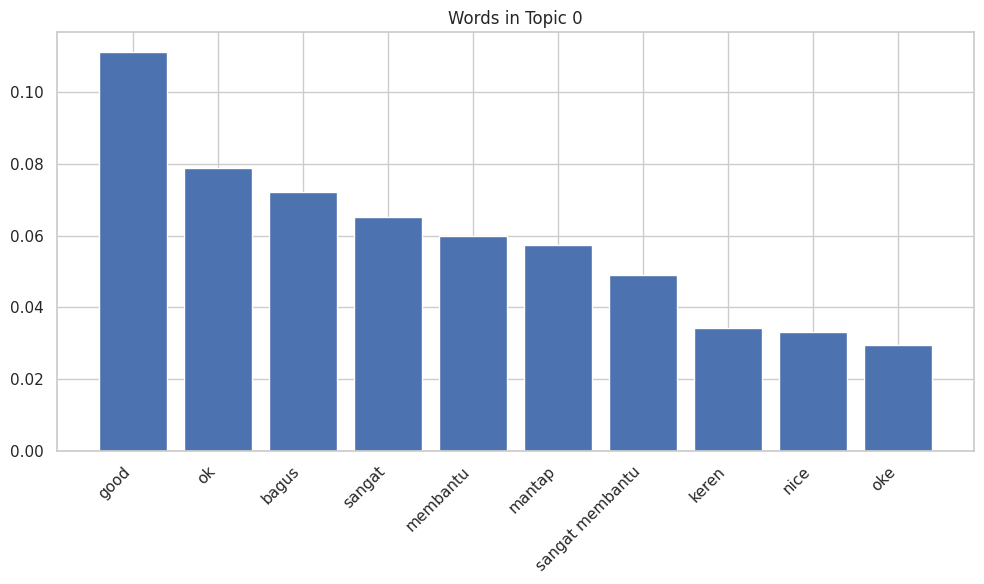

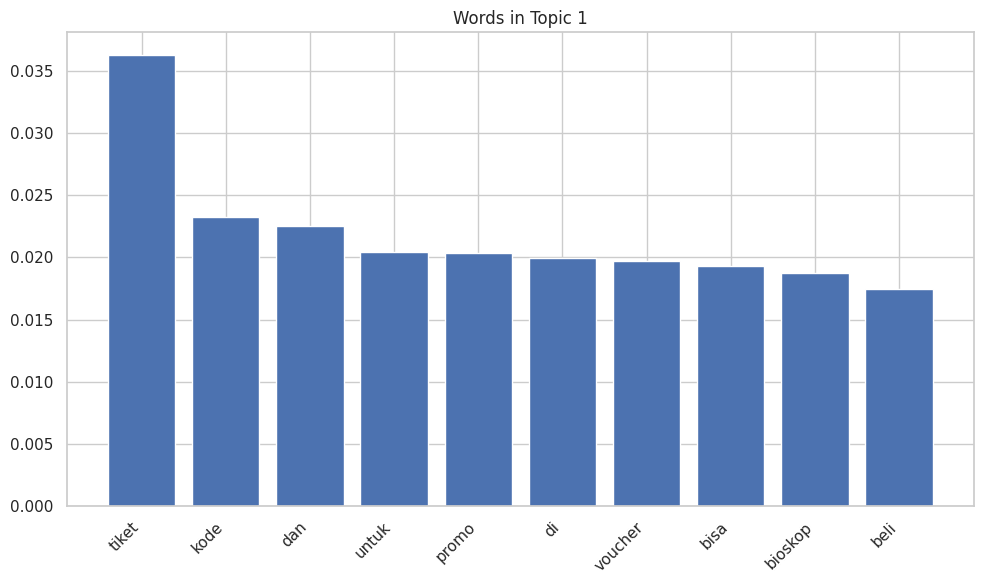

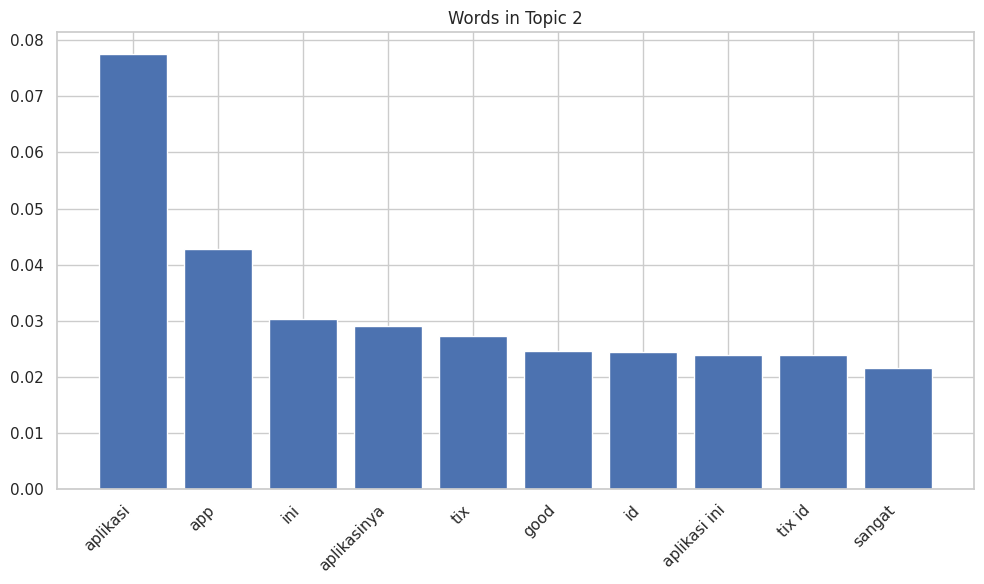

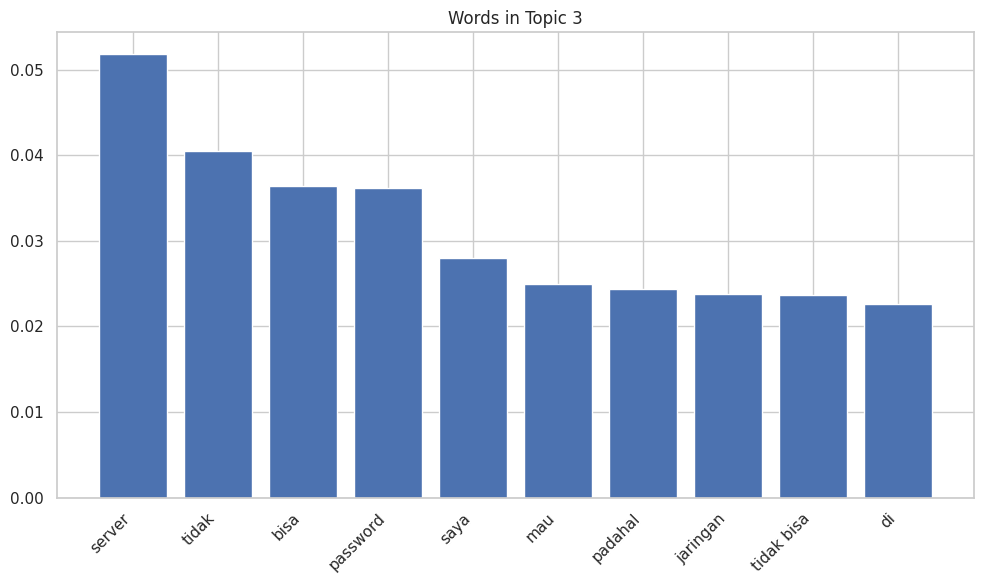

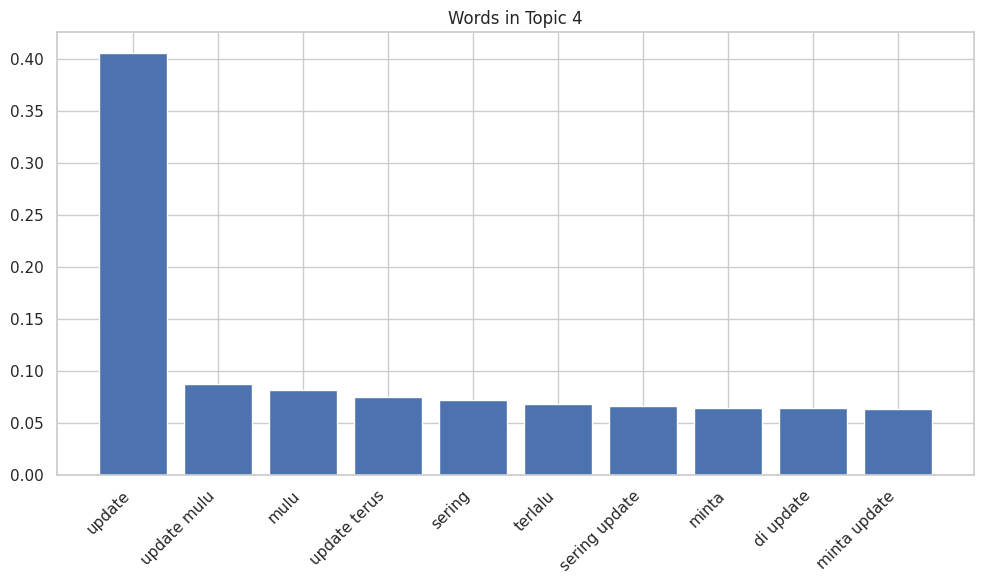

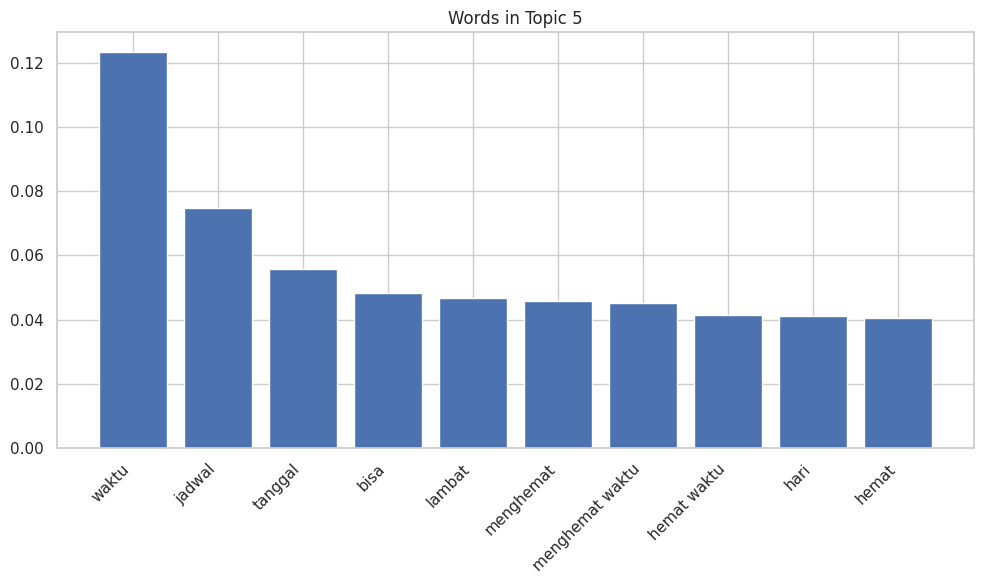

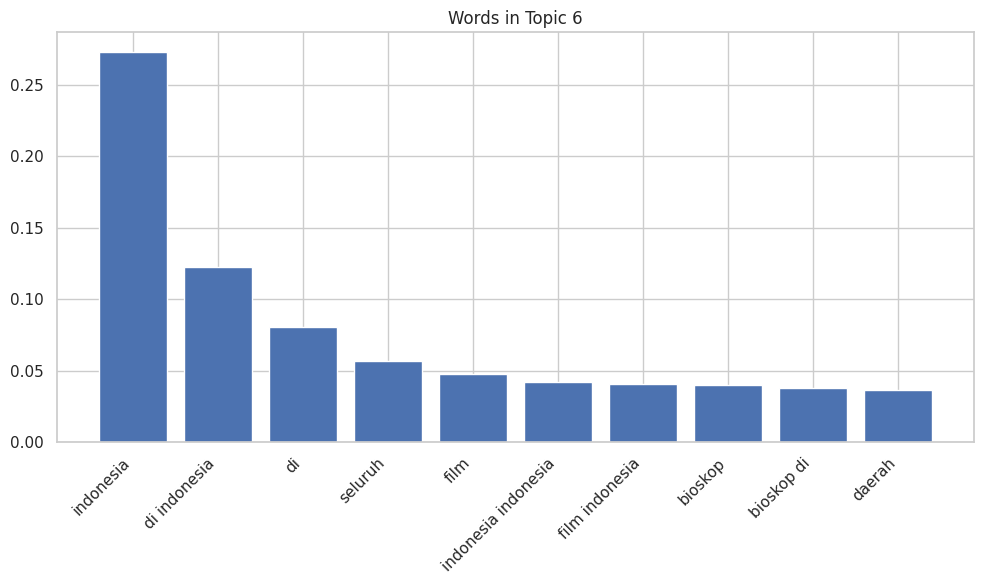

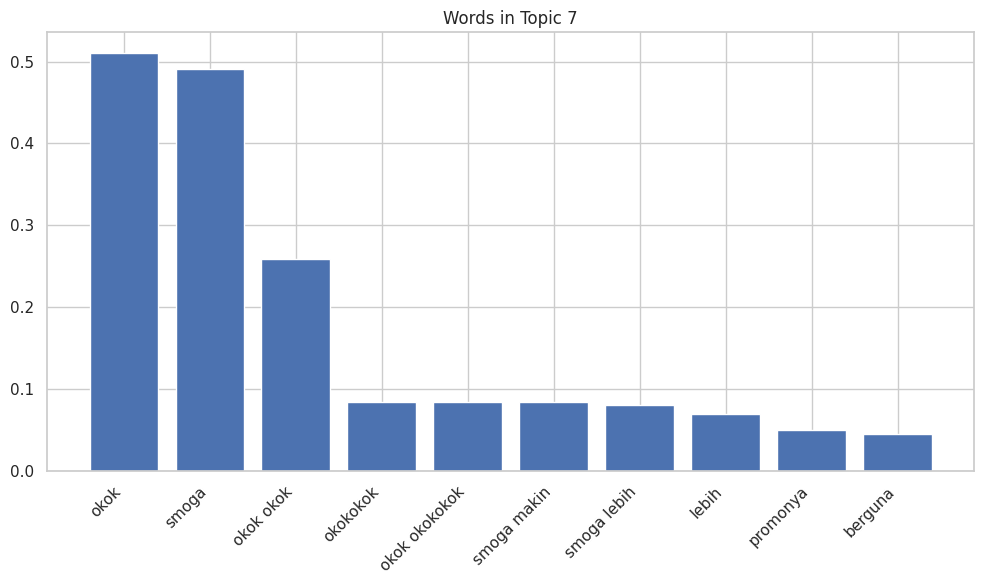

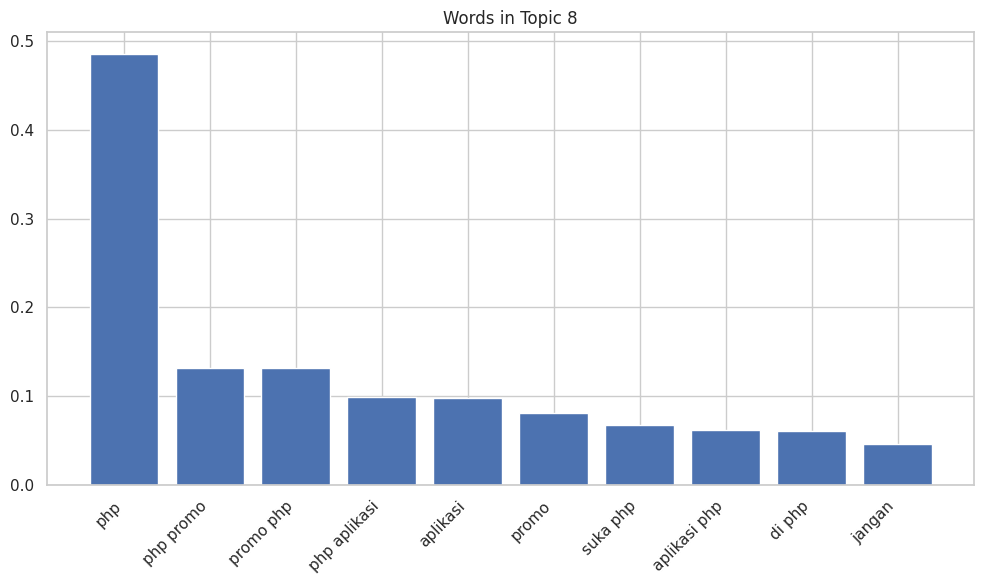

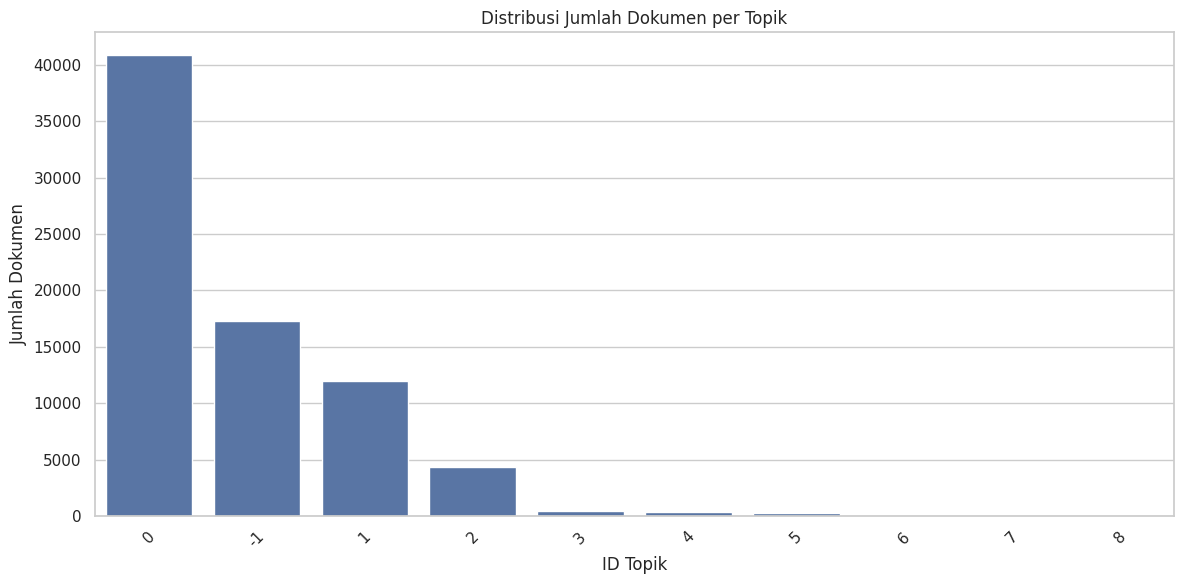

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ambil top 10 topik teratas (kecuali outlier -1)
top_topics = topic_model.get_topic_freq().head(10)['Topic'].tolist()

# Fungsi untuk plot kata penting dalam satu topik
def plot_topic_word_scores(topic_model, topic_id):
    topic = topic_model.get_topic(topic_id)
    if not topic:
        return None

    words = [word for word, _ in topic]
    scores = [score for _, score in topic]

    plt.figure(figsize=(10, 6))
    plt.bar(words, scores)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Words in Topic {topic_id}')
    plt.tight_layout()
    plt.show()

# Plot untuk setiap topik utama
for topic_id in top_topics:
    if topic_id != -1:
        plot_topic_word_scores(topic_model, topic_id)

# Plot distribusi jumlah dokumen per topik
plt.figure(figsize=(12, 6))
sns.countplot(x='10_topics', data=clean_data, order=clean_data['10_topics'].value_counts().index)
plt.title('Distribusi Jumlah Dokumen per Topik')
plt.xlabel('ID Topik')
plt.ylabel('Jumlah Dokumen')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Ambil semua topik (kecuali outlier -1)
all_topics = topic_model.get_topic_freq()['Topic'].tolist()
all_topics = [t for t in all_topics if t != -1]  # Hapus -1 (outlier)

# Tampilkan top words per topik
for topic_id in all_topics:
    print(f"\n=== Topik {topic_id} ===")
    top_words = topic_model.get_topic(topic_id)
    for word, score in top_words:
        print(f"{word}: {score:.4f}")



=== Topik 0 ===
good: 0.1112
ok: 0.0788
bagus: 0.0721
sangat: 0.0653
membantu: 0.0598
mantap: 0.0574
sangat membantu: 0.0491
keren: 0.0343
nice: 0.0331
oke: 0.0296

=== Topik 1 ===
tiket: 0.0363
kode: 0.0232
dan: 0.0225
untuk: 0.0205
promo: 0.0204
di: 0.0199
voucher: 0.0197
bisa: 0.0194
bioskop: 0.0188
beli: 0.0175

=== Topik 2 ===
aplikasi: 0.0775
app: 0.0429
ini: 0.0304
aplikasinya: 0.0291
tix: 0.0273
good: 0.0247
id: 0.0244
aplikasi ini: 0.0240
tix id: 0.0239
sangat: 0.0217

=== Topik 3 ===
server: 0.0518
tidak: 0.0405
bisa: 0.0364
password: 0.0362
saya: 0.0280
mau: 0.0249
padahal: 0.0243
jaringan: 0.0238
tidak bisa: 0.0237
di: 0.0227

=== Topik 4 ===
update: 0.4051
update mulu: 0.0874
mulu: 0.0815
update terus: 0.0752
sering: 0.0716
terlalu: 0.0680
sering update: 0.0664
minta: 0.0641
di update: 0.0640
minta update: 0.0635

=== Topik 5 ===
waktu: 0.1232
jadwal: 0.0746
tanggal: 0.0557
bisa: 0.0483
lambat: 0.0468
menghemat: 0.0457
menghemat waktu: 0.0452
hemat waktu: 0.0415
hari: 0.0